<a href="https://colab.research.google.com/github/hyj765/AI-study/blob/main/DCGan_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Reshape,Conv2D,Conv2DTranspose,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np

In [ ]:
latent_dim = 32
height = 32
width = 32
channels = 3

In [ ]:
G_input = Input(shape=(latent_dim))

In [ ]:
x = Dense(128*16*16)(G_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)
x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(256,4,strides=2 ,padding='same')(x)
x = LeakyReLU()(x)
x= Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x= Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x= Conv2D(channels,7,activation='tanh',padding='same')(x)

In [ ]:
generator = Model(G_input,x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [ ]:
D_input = Input(shape=(height,width,channels))

In [ ]:
x = Conv2D(128,3)(D_input)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1,activation='sigmoid')(x)

In [ ]:
discriminator = Model(D_input,x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

In [ ]:
d_op = RMSprop(lr=0.0004,clipvalue =1.0, decay=1e-8)
discriminator.compile(optimizer=d_op,loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input,gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue = 1.0,decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         6264579   
                                                                 
 model_1 (Functional)        (None, 1)                 790913    
                                                                 
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

In [ ]:
(x_train,y_train),(_,_) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
x_train = x_train[y_train.flatten() == 6]

In [ ]:
x_train.shape

(5000, 32, 32, 3)

In [ ]:
x_train = x_train.reshape((x_train.shape[0],)+(height,width,channels)).astype('float32')/255

In [ ]:
import os
iterations =10000
batch_size = 20

save_dir = '/content/gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)


In [ ]:
start = 0
for step in range(iterations):
  random_latent = np.random.normal(size=(batch_size,latent_dim))
  gernerated_images = generator.predict(random_latent)
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([gernerated_images,real_images])
  
  labels = np.concatenate([np.ones((batch_size,1)),
                           np.zeros((batch_size,1))])
  labels += 0.05 * np.random.random(labels.shape) 
  d_loss = discriminator.train_on_batch(combined_images,labels)
  random_latent = np.random.normal(size=(batch_size,latent_dim))
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent,misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start  =0 
  
  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print('\n step: {}'.format(step))
    print(' discriminator loss: {}'.format(d_loss))
    print('adversarialloss: {}'.format(a_loss))

    img = image.array_to_img(gernerated_images[0]* 255., scale =False)
    img.save(os.path.join(save_dir,'generated_frog' +str(step)+'.png'))


 step: 0
 discriminator loss: 0.7020300030708313
adversarialloss: 0.6964287757873535

 step: 100
 discriminator loss: 0.6881148219108582
adversarialloss: 1.4949389696121216

 step: 200
 discriminator loss: 0.713840663433075
adversarialloss: 0.7282712459564209

 step: 300
 discriminator loss: 0.7066095471382141
adversarialloss: 0.7853308320045471

 step: 400
 discriminator loss: 0.7000870704650879
adversarialloss: 0.749151885509491

 step: 500
 discriminator loss: 0.6930333971977234
adversarialloss: 0.7281001210212708

 step: 600
 discriminator loss: 0.6975765228271484
adversarialloss: 0.7522223591804504

 step: 700
 discriminator loss: 0.6965371370315552
adversarialloss: 0.7447272539138794

 step: 800
 discriminator loss: 0.697443425655365
adversarialloss: 0.7442620992660522

 step: 900
 discriminator loss: 0.7015034556388855
adversarialloss: 0.7491888999938965

 step: 1000
 discriminator loss: 0.7132207751274109
adversarialloss: 0.8584348559379578

 step: 1100
 discriminator loss: 0.

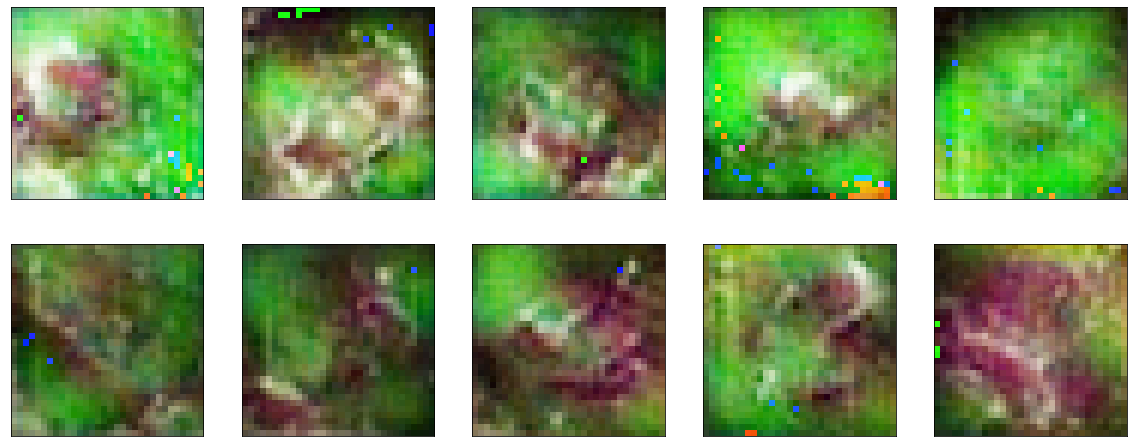

In [ ]:
import matplotlib.pyplot as plt

random_latent_vectors =np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
plt.figure(figsize=(20,8))
for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  img = image.array_to_img(generated_images[i]*255.,scale=False)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()